In [14]:
import pandas as pd
import missingno as msno
import seaborn as sns
import datetime as dt
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
df_migration_pre = pd.read_csv("dataset_migration.csv")
df_hdi_pre = pd.read_csv("HDI_Index.csv")

In [15]:
#Funciones de preprocesamiento
def dateto_ordinal(df,date_column):
    #Función para convertir fecha a tipo ordinal
    df['Fecha_Numerico']=df[date_column].map(dt.datetime.toordinal)
    return df

def country_code_num(df):
    #Funcion para crear diccionario codigo pais y "label_encoder"
    country_code = df["Country Code"].unique()
    country_code = country_code.tolist()
    country_code_c = {}
    keys = country_code
    values = range(1, len(keys)+1)
    for key, value in zip(keys, values):
        country_code_c[key] = value
    #Add new column Country_code_num
    df["country_code_c"] = df["Country Code"].map(country_code_c)
    #Funcion para crear diccionario id pais y "label_encoder"
    num_country_code = {v: k for k, v in country_code_c.items()}
    return df

def clearna (df):
    #Funcion para eliminar registros nulos
    df.dropna(inplace=True)
    return df

def dropcolumns_for_ml(df):
    #Funcion para dejar columnas de tipo float para el modelo de ml
    df = df.drop(["Country Code","Year","Unemployment Advanced Education (%)","Unemployment Intermediate Education (%)", "Unemployment Basic Education (%)","Labor Taxes and Contributions (%)","Social Protection and Labor Programs (%)","Poverty Rate (%)"],axis=1)
    return df

def dropcolumns(df):
    #Funcion para eliminar columnas
    df = df.drop(["Unemployment Advanced Education (%)","Unemployment Intermediate Education (%)", "Unemployment Basic Education (%)","Labor Taxes and Contributions (%)","Social Protection and Labor Programs (%)","Poverty Rate (%)"],axis=1)
    return df

def preprodata(df_migration,df_hdi):
    #Funcion para preprocesamiento de datos
    #unir dataframes
    df = df_migration.merge(df_hdi, how="left", on=["Country Name", "Country Code", "Year"])
    #eliminar columnas redundanes o que no tienen importancia en el modelo
    df.drop(["Unnamed: 0_x","Unnamed: 0_y"], axis= 1, inplace=True)
    df.drop("PIB Growth (%)", axis= 1, inplace=True)
    #Convertir year as date
    df["Year"] = pd.to_datetime(df["Year"].astype(str),format= "%Y")
    df= dateto_ordinal(df,"Year")
    df = country_code_num(df)
    df_ml = df
    df = dropcolumns(df)
    df = clearna(df)
    df_ml = dropcolumns_for_ml(df_ml)
    df_ml = clearna(df_ml)
    return df_ml , df

#Función para reducir datos ssegun lista de paises determinado
def country_reduce(df,list_country):
    mask = df["Country Name"].isin(list_country)
    df_filtered = df[mask]
    return df_filtered

#Función para convertir año en formato (str) a número ordinal
def convert_year_to_ordinal(year_input):
    year_num = datetime.strptime(year_input,'%Y').toordinal()
    return year_num

#Funcion para elegir datos por un año
def year_filter(df,year_str):
    year_num = convert_year_to_ordinal(year_str)
    mask = df["Fecha_Numerico"] == year_num 
    df_filtered = df[mask]
    return df_filtered

#Funcion para elegir datos por un intervalo de años
def year_filter_range(df,year_str_min,year_str_max):
    year_num_min = convert_year_to_ordinal(year_str_min)
    year_num_max = convert_year_to_ordinal(year_str_max)
    mask = (df.Fecha_Numerico>=year_num_min)&(df.Fecha_Numerico<= year_num_max)
    df_filtered = df[mask]
    return df_filtered

#Add labels to Dataframes
def add_labels(df,labels_in):
    df["labels"] =labels_in
    return df

#Function to show clusters
def func_groupby(df):
    df_group = df.groupby("labels").value_counts().reset_index(name='count')
    print(df.groupby("labels")["Country Name"].value_counts())
    df_group =df_group.drop("count",axis=1)
    return df_group

In [16]:
#Funciones para ejecutar modelo no supervisado
def func_scaler(df):
    #Escalado de todos los features Min_Max scaler
    X_in = df.drop(["Fecha_Numerico","Country Name"],axis=1).values
    # Import MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler
    # Instantiate MinMaxScaler
    MM_scaler = MinMaxScaler()
    # Fit MM_scaler to the data
    MM_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = MM_scaler.transform(X_in)
    return X

def func_scaler_standard(df):
    X_in = df.drop(["Fecha_Numerico","Country Name"],axis=1).values
    #Escalar X
    #Escalado de todos los features Min_Max scaler
    # Import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    # Instantiate MinMaxScaler
    STD_scaler = StandardScaler()
    # Fit MM_scaler to the data
    STD_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = STD_scaler.transform(X_in)
    return X

def func_clusters(X_in,number_of_clusters):
    from sklearn.cluster import KMeans
    kmeans=KMeans(n_clusters=number_of_clusters,random_state=0)
    kmeans.fit(X_in)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    return labels, centroids

In [17]:
#Función para ejecutar elbow-method
def elbow_metodo(df,c_min,c_max):
    # Creamos una lista donde iremos guardando las distancias medias
    Sum_of_squared_distances = []
    X = func_scaler(df)

    # Entrenamos un modelo para cada número de cluster que queremos testear
    K = np.arange(c_min,c_max)
    for k in K:
        # Definimos y entrenamos el modelo
        km = KMeans(n_clusters=k)
        km = km.fit(X)
    
        # Calculamos la distancia media y agregamos a la lista
        distancia_total = km.inertia_
        distancia_media = np.divide(distancia_total,X.shape[0])
        Sum_of_squared_distances.append(distancia_media)

    plt.figure(figsize = (10,7))
    plt.plot(K, Sum_of_squared_distances, lw=3)
    plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
    plt.xlabel('Cantidad de clusters K')
    plt.ylabel('Inercia media')
    plt.title('Método del codo para el dataset 1')
    plt.show()
    return 

In [26]:
#Función para ejecutar Silhouette Score
def silhouette_metodo(df,c_min,c_max):
    from sklearn.metrics import silhouette_samples, silhouette_score
    #Método Silhouette
    # Creamos una lista donde iremos guardando los valores medios de silhouette
    lista_sil = []
    # Ingresamos el Dataset con el que queremos trabajar
    X = func_scaler(df)
    K = np.arange(c_min,c_max)
    # Entrenamos un modelo para cada número de cluster que queremos testear
    for k in range(c_min,c_max):
        # Definimos y entrenamos el modelo
        km = KMeans(n_clusters=k)
        km = km.fit(X)
    
        # Tomamos las etiquetas
        etiquetas = km.labels_
    
        # Calculamos el silhouette 
        valor_medio_sil = silhouette_score(X, etiquetas)
        lista_sil.append(valor_medio_sil)
    
    plt.figure(figsize = (10,7))
    plt.plot(K, lista_sil, lw=3)
    plt.scatter(K, lista_sil,s=55,c='r')
    plt.xlabel('Cantidad de clusters K')
    plt.ylabel('Silhouette media')
    plt.title('Silhouette media para el dataset 1', fontsize = 15)

    plt.show()
    return 

In [19]:
#Hierarchical clustering - Dendogram (Para ver el clustering jerarquico)
def hiercluster(X_in,df):
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import linkage, dendrogram
    samples = X_in
    mergings = linkage(samples, method='complete')
    country_name = df['Country Name'].to_list()
    dendrogram(mergings,
    labels = country_name,
    leaf_rotation=90,
    leaf_font_size=6)
    # plotting a line plot after changing it's width and height
    plt.rcParams["figure.figsize"] = [6.5, 15]
    plt.show()

In [20]:
#Lista de paises para el modelo ML paises receptores y emisores en conjunto
country_list =['Afganistán','Francia','China','Canadá','India','España',
                'México','Alemania','Venezuela','Italia','Pakistán','Estados Unidos',
               'Ucrania','Arabia Saudita','Bangladesh','Australia','República Árabe Siria',	
               'Reino Unido','Yemen, Rep. del','Federación de Rusia']

#Ejecución función de preprocesamiento
dfm_total_ml, dfm_total = preprodata(df_migration_pre,df_hdi_pre)
dfm_ml = country_reduce(dfm_total_ml,country_list)
dfm_total = country_reduce(dfm_total,country_list)

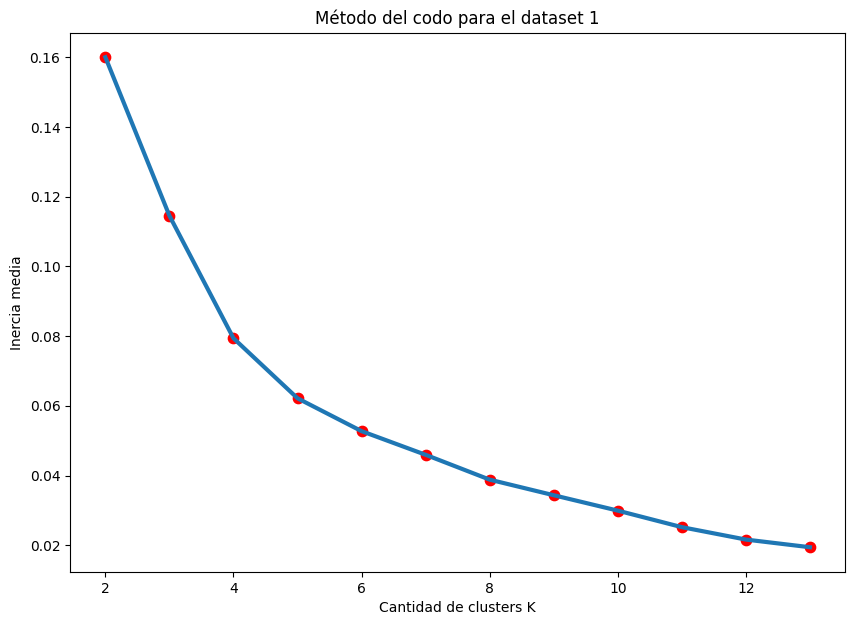

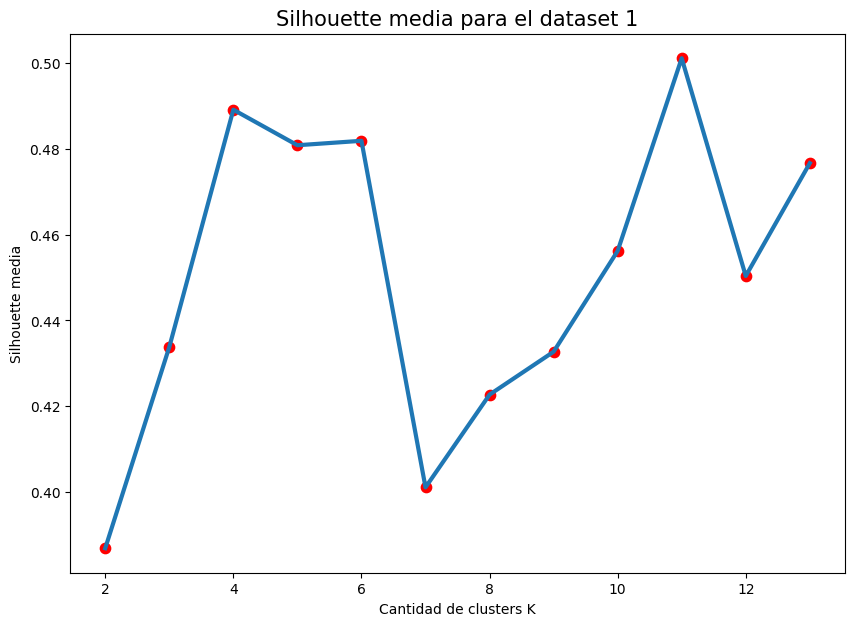

labels  Country Name         
0       India                    21
        Pakistán                 21
        México                    2
1       Yemen, Rep. del          19
        República Árabe Siria    18
        Venezuela                 5
        Ucrania                   2
2       Alemania                 21
        Australia                21
        Canadá                   21
        España                   21
        Francia                  21
        Italia                   21
        Reino Unido              21
        China                    10
3       Arabia Saudita           21
        Federación de Rusia      21
        México                   19
        Ucrania                  19
        Venezuela                10
        República Árabe Siria     3
4       Bangladesh               21
        Afganistán               19
        China                    11
5       Estados Unidos           21
Name: Country Name, dtype: int64


In [21]:
#Ejecución del código y funciones de modelo no supervisado para el dataframe dfm_ml
elbow_metodo(dfm_ml,2,14)
silhouette_metodo (dfm_ml,2,14)
X = func_scaler(dfm_ml)
labels, centroids = func_clusters(X,6)
dfm_ml = add_labels(dfm_ml,labels)
df_group = func_groupby(dfm_ml)

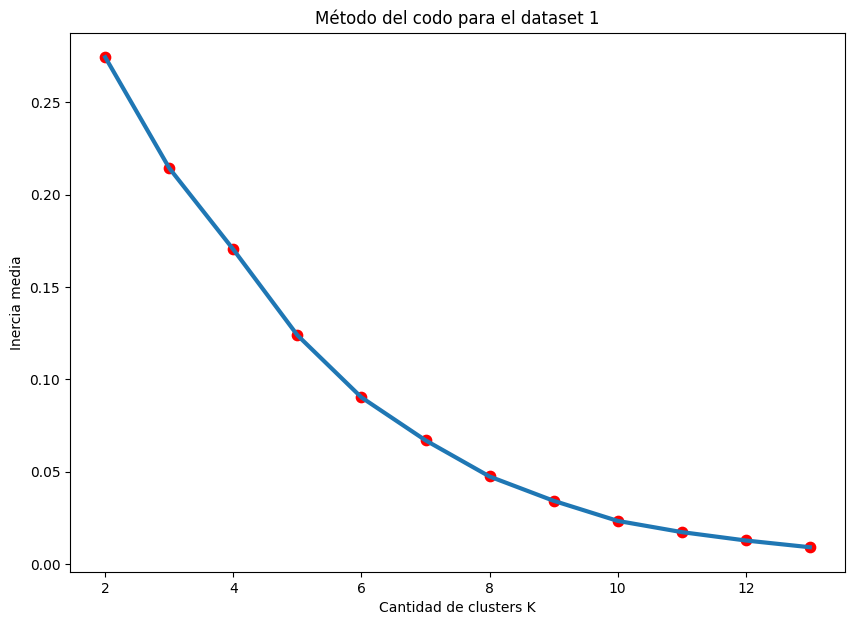

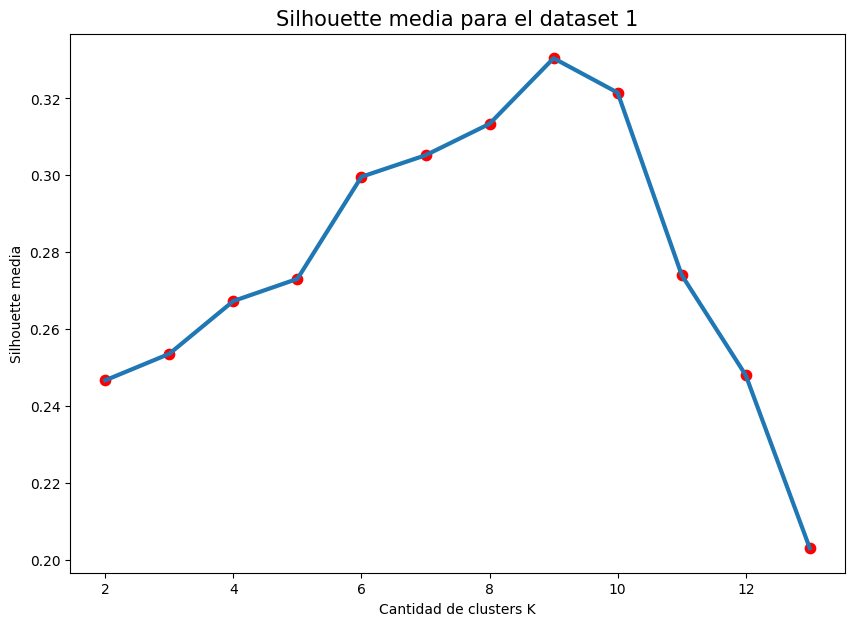

labels  Country Name         
0       Afganistán               1
        Bangladesh               1
        India                    1
1       Arabia Saudita           1
        Federación de Rusia      1
        México                   1
        Ucrania                  1
2       Alemania                 1
        Australia                1
        Canadá                   1
        China                    1
        Reino Unido              1
3       Estados Unidos           1
4       República Árabe Siria    1
        Yemen, Rep. del          1
5       España                   1
        Francia                  1
        Italia                   1
6       Pakistán                 1
Name: Country Name, dtype: int64


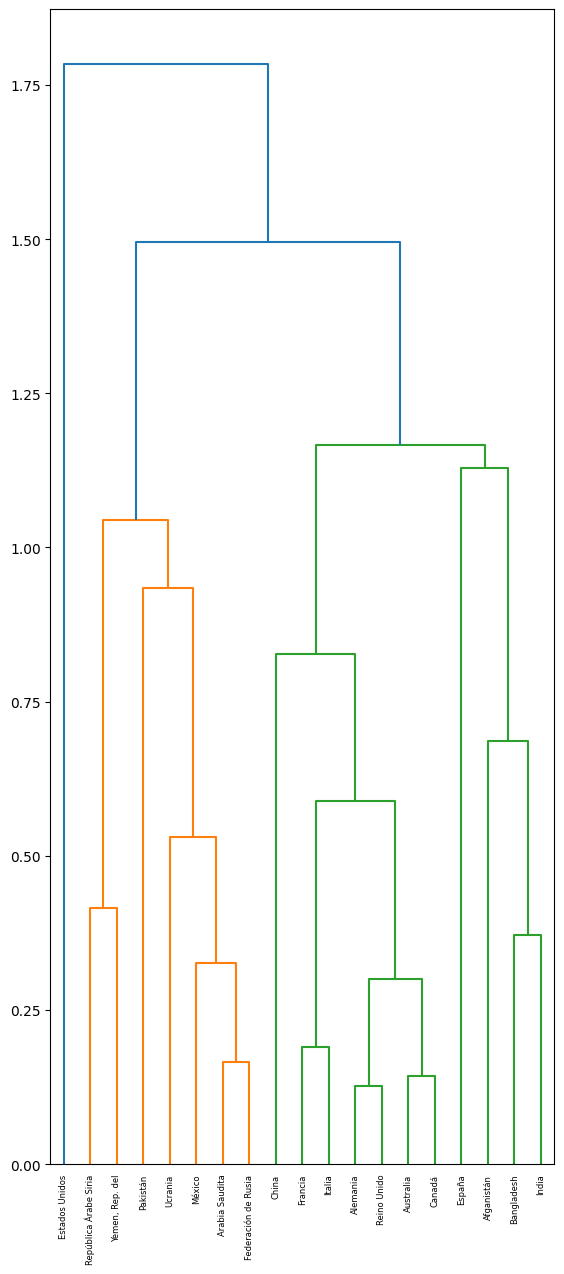

In [22]:
#Calculo promedio últimos 5 años
start = '2015'
stop = '2020'
start = convert_year_to_ordinal(start)
stop = convert_year_to_ordinal(stop)
dfm_ml_range = dfm_ml[(dfm_ml.Fecha_Numerico>=start)&(dfm_ml.Fecha_Numerico<=stop)]
dfm_ml_range = dfm_ml_range.groupby('Country Name', as_index=False)["Net Migration","PIB per Capita","Total Unemployment (%)","human_development_index","Fecha_Numerico","country_code_c"].mean()
elbow_metodo(dfm_ml_range,2,14)
silhouette_metodo (dfm_ml_range,2,14)
X = func_scaler(dfm_ml_range)
labels, centroids = func_clusters(X,7)
dfm_ml_range = add_labels(dfm_ml_range,labels)
df_group_range = func_groupby(dfm_ml_range)
hiercluster(X,dfm_ml_range)

In [23]:
#Generación de cluster - 2
X = func_scaler(dfm_ml)
labels_2, centroids_2 = func_clusters(X,2)
dfm_ml = add_labels(dfm_ml,labels_2)
df_group_2 = func_groupby(dfm_ml)
df_group_2.labels.value_counts()
df_group_2.to_csv("df_group_2.csv",index=False)

labels  Country Name         
0       Alemania                 21
        Australia                21
        Bangladesh               21
        Canadá                   21
        China                    21
        España                   21
        Francia                  21
        India                    21
        Italia                   21
        Reino Unido              21
        Afganistán               19
1       Arabia Saudita           21
        Estados Unidos           21
        Federación de Rusia      21
        México                   21
        Pakistán                 21
        República Árabe Siria    21
        Ucrania                  21
        Yemen, Rep. del          19
        Venezuela                15
Name: Country Name, dtype: int64


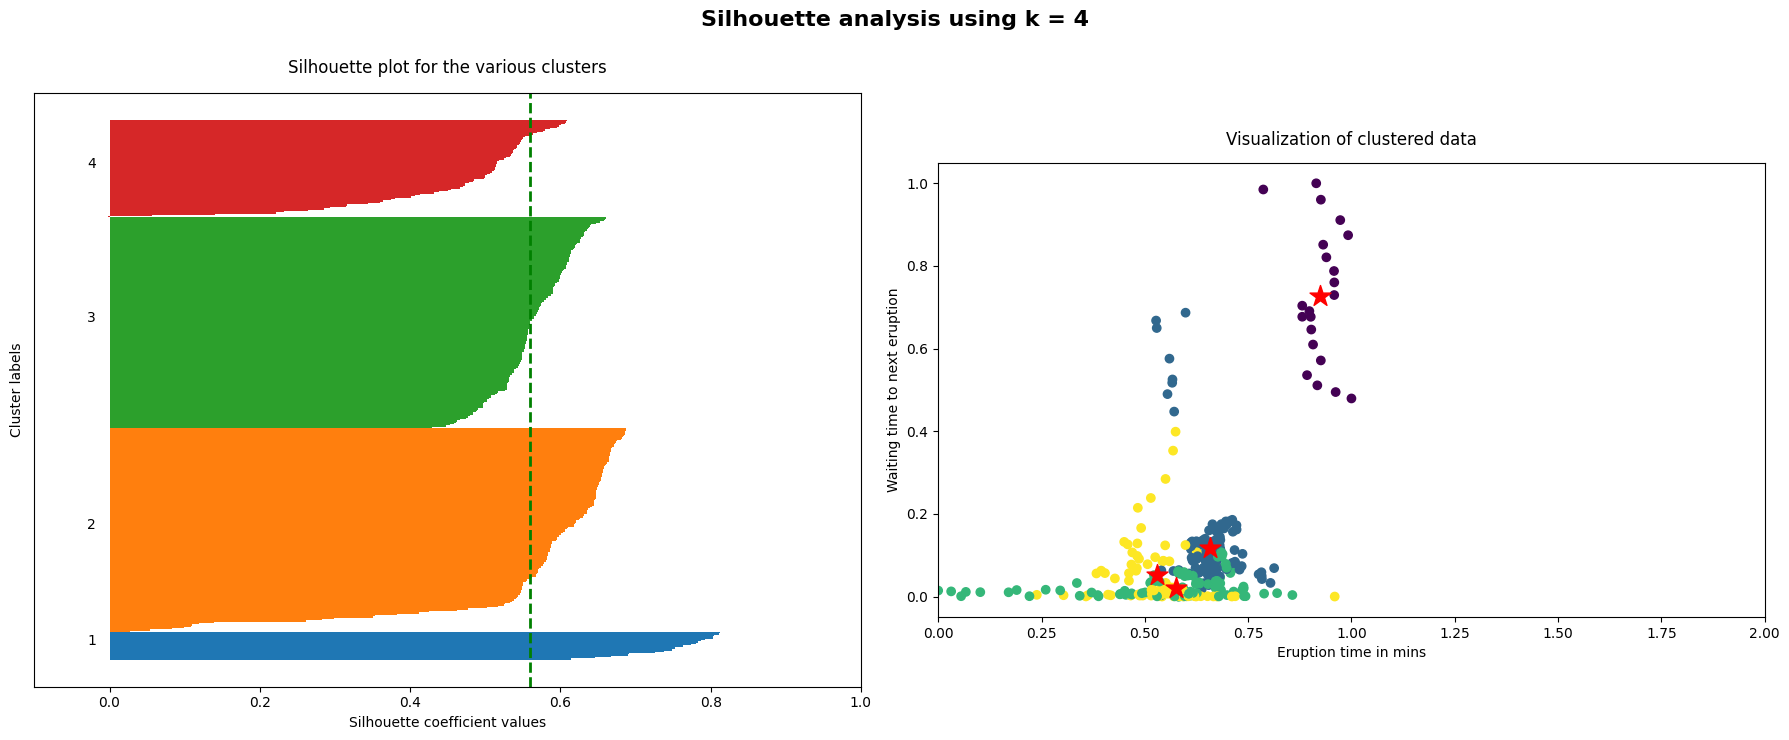

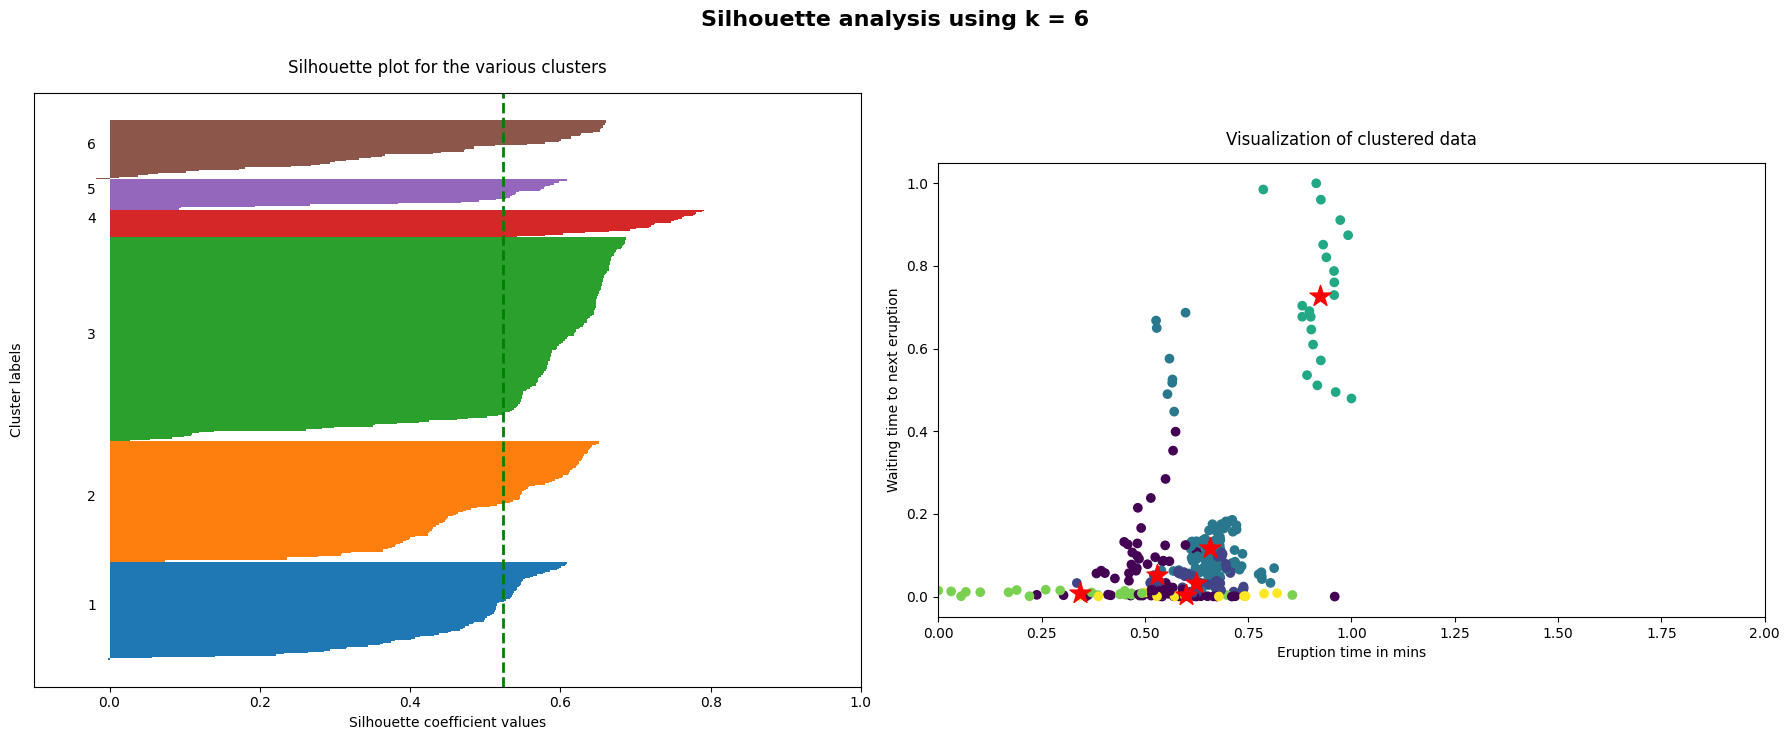

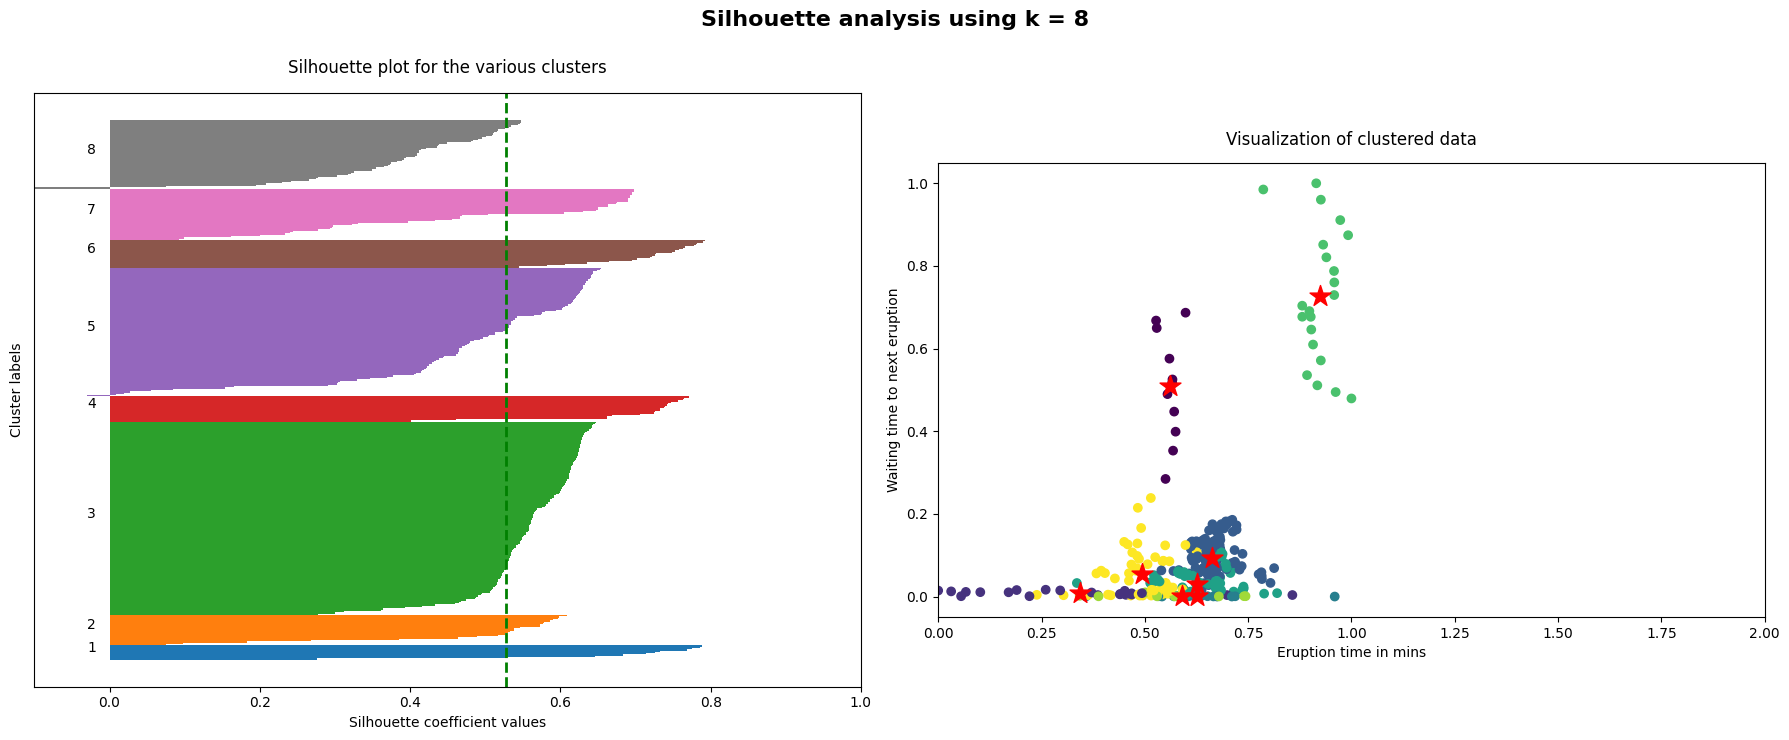

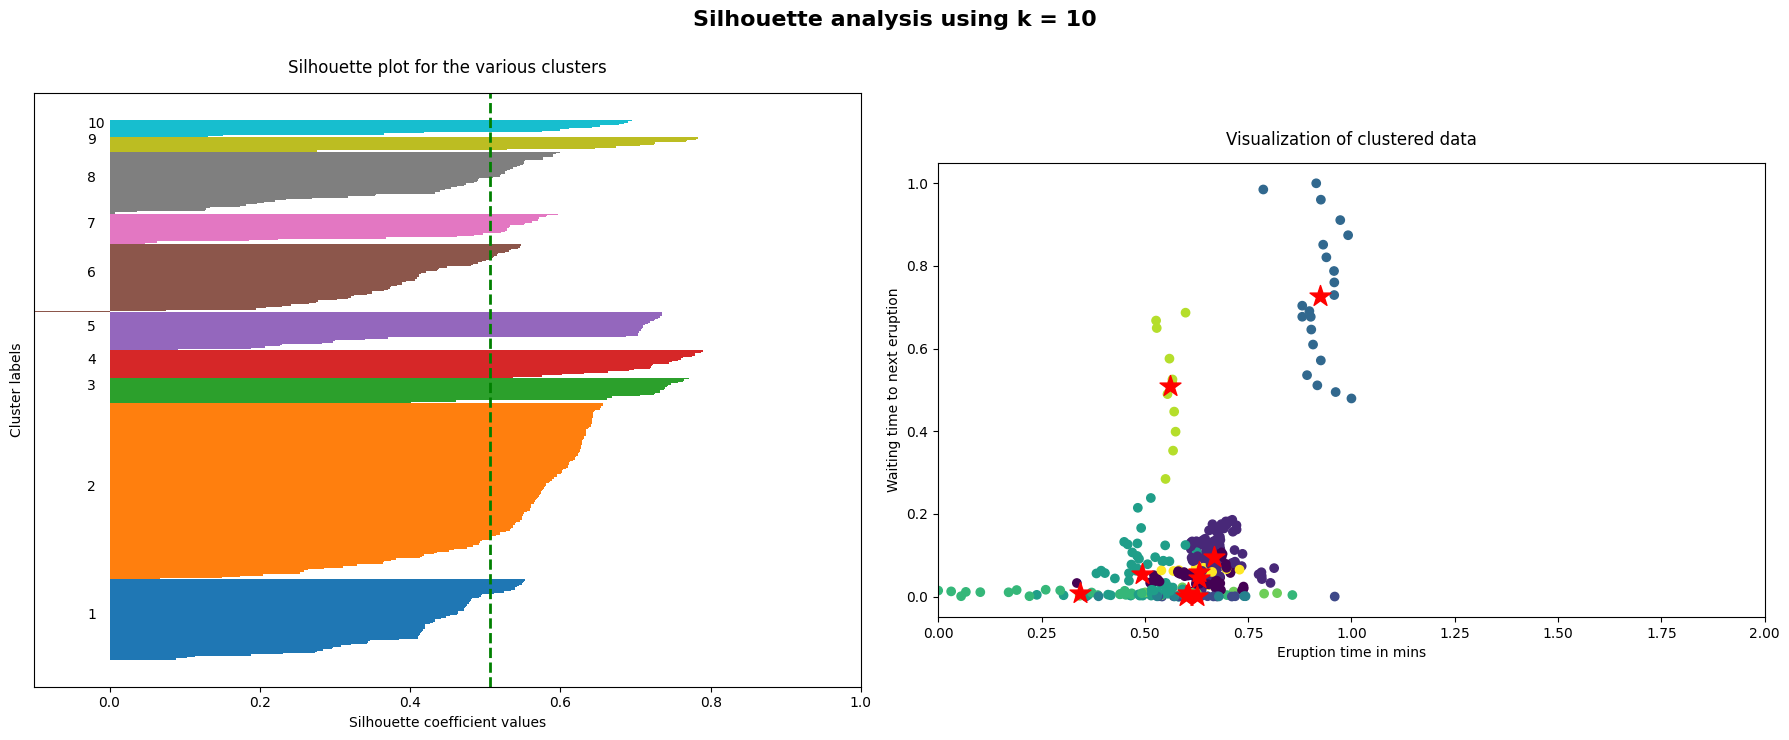

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Ingresamos el Dataset con el que queremos trabajar
X_std = func_scaler(dfm_ml)

# Definimos la lista de los K que queremos graficae
lista_k = [4, 6, 8, 10]

for i, k in enumerate(lista_k):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Instanciamos el modelo
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    silhouette_vals = silhouette_samples(X_std, labels)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([0, 2])
    ax2.set_xlim([0, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

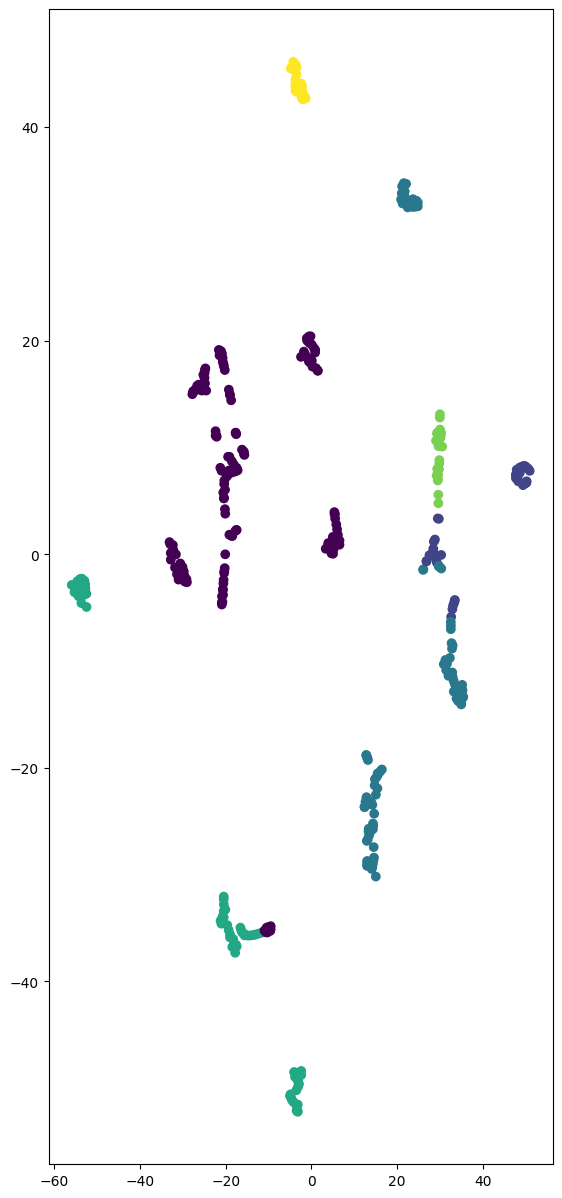

In [25]:
#tsne-visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
dfm_ml_year = year_filter(dfm_ml,"2020")
dfm_ml = dfm_ml

def tsne_visual(df,number_clusters,perplexiti_in,):
    X = func_scaler(df)
    #En labels podria ser usar el encoding del nombre de paises
    labels, centroids = func_clusters(X,number_clusters)
    model = TSNE(learning_rate=100,perplexity = perplexiti_in)
    transformed = model.fit_transform(X)
    xs = transformed[:,0]
    ys = transformed[:,1]
    plt.scatter(xs, ys, c=labels)
    plt.show()

tsne_visual(dfm_ml,6,15)